# MobileNetV2/V3Large Model with Kaggle data

source of dataset: [https://www.kaggle.com/datasets/gpiosenka/100-bird-species](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)

References used within this notebook:
- [1] [https://www.tensorflow.org/tutorials/images/classification](https://www.tensorflow.org/tutorials/images/classification)
- [2] [https://www.tensorflow.org/tutorials/load_data/images](https://www.tensorflow.org/tutorials/load_data/images)
- [3] [https://keras.io/api/applications/#usage-examples-for-image-classification-models](https://keras.io/api/applications/#usage-examples-for-image-classification-models)
- [4] [https://www.kaggle.com/code/abduulrahmankhalid/birds-species-prediction-mobilenetv2-acc-95](https://www.kaggle.com/code/abduulrahmankhalid/birds-species-prediction-mobilenetv2-acc-95)
- [5] [https://keras.io/guides/transfer_learning/](https://keras.io/guides/transfer_learning/)

---

# Content
### 1) Get data insights
### 2) Train the model
### 3) Evaluation
### 4) Save model, history and parameters
### 5) Retrain model
### 6) Making some predictions

---

# 1) Get data insights

In [1]:
import os
import pathlib
import random
import numpy as np
import pandas as pd
import pickle
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import mlflow

#from modeling.config import EXPERIMENT_NAME
from config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

import tensorflow as tf
from tensorflow import keras

#### Set paths to data

In [2]:
DATASET = 'europe-40' # or 'kaggle+europe' or 'europe'

# Get current absolute path of parent folder of this file
path_notebooks = os.path.dirname(os.path.abspath('mlflow_3_MobileNetV2_Kaggle_finetuned'))

# Get path of parent directory, i.e. path to repo
path = os.path.abspath(os.path.join(path_notebooks, os.pardir))

train_dir = path + '/data/europe-40/train/'
val_dir = path + '/data/europe-40/valid/'
test_dir = path + '/data/europe-40/test/'

# create pathlib object from string train_dir (path to train directory)
train_dir_pl = pathlib.Path(train_dir)

In [3]:
# How many training images do we have?
image_count = len(list(train_dir_pl.glob('*/*.jp*')))
print(f'Number of training samples: {image_count}')

Number of training samples: 5311


## Load data using a Keras utility

In [4]:
# Define parameters
BATCH_SIZE = 512
IMG_HEIGHT = 300
IMG_WIDTH = 300

In [5]:
# Import data
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      color_mode='rgb',
                                                      shuffle=True,
                                                      label_mode = 'categorical',
                                                      batch_size = BATCH_SIZE,
                                                      image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                      seed=None,
                                                      validation_split=None,
                                                      crop_to_aspect_ratio=True,
                                                      interpolation='bilinear')

val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                      color_mode='rgb',
                                                      label_mode ='categorical',
                                                      batch_size = BATCH_SIZE,
                                                      image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                      seed=None,
                                                      validation_split=None,
                                                      crop_to_aspect_ratio=True,
                                                      interpolation='bilinear')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      color_mode='rgb',
                                                      label_mode ='categorical',
                                                      batch_size = BATCH_SIZE,
                                                      image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                      seed=None,
                                                      validation_split=None,
                                                      crop_to_aspect_ratio=True,
                                                      interpolation='bilinear')                                                      

Found 5311 files belonging to 40 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Found 200 files belonging to 40 classes.
Found 200 files belonging to 40 classes.


2022-11-17 00:37:13.453516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 00:37:13.453822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Get class names
class_names = train_ds.class_names
print(class_names)

['BARN SWALLOW', 'BLACK REDSTART', 'BLACKBIRD', 'CARRION CROW', 'CHIFFCHAFF', 'COAL TIT', 'COLLARED DOVE', 'COMMON CHAFFINCH', 'COMMON HOUSE MARTIN', 'COMMON REDSTART', 'COMMON STARLING', 'COMMON SWIFT', 'COMMON WOOD PIGEON', 'CRESTED NUTHATCH', 'DUNNOCK', 'EURASIAN BLACK CAP', 'EURASIAN BULLFINCH', 'EURASIAN MAGPIE', 'EURASIAN WREN', 'EURASIEN BLUE TIT', 'EURASIEN JAY', 'EURASIEN TREE SPARROW', 'EUROPEAN GOLDFINCH', 'EUROPEAN GREENFINCH', 'EUROPEAN JACKDAW', 'EUROPEAN SERIN', 'GARDEN WARBLER', 'GREAT SPOTTED WOODPECKER', 'GREAT TIT', 'HOUSE SPARROW', 'LESSER WHITETHROAT', 'LONG TAILED TIT', 'ROBIN', 'ROOK', 'SHORT-TOED TREECREEPER', 'SONG THRUSH', 'SPOTTED FLYCATCHER', 'WHITE WAGTAIL', 'WILLOW WARBLER', 'YELLOWHAMMER']


### First visual impression
- using PIL (python image library) for first two images
- using matplotlib.image for two additional images

In [ ]:
# Create list of paths to all birds of class 'ABBOTTS BABBLER' and show first two birds
abbotts_babbler = list(train_dir_pl.glob('ABBOTTS BABBLER/*'))

In [ ]:
img1 = PIL.Image.open(str(abbotts_babbler[0]))
print(f"Image shape: {img1.size}")
img1

In [ ]:
img2 = PIL.Image.open(str(abbotts_babbler[1]))
print(f"Image shape: {img2.size}")
img2

The following function is taken from [4]

In [ ]:
def view_random_image(target_dir, target_class):
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = mpimg.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  
  return img

In [ ]:
img3 = view_random_image(target_dir = train_dir,
                        target_class = '/BAY-BREASTED WARBLER'
                        )

In [ ]:
img4 = view_random_image(target_dir = train_dir,
                        target_class = '/GOLDEN EAGLE'
                        )

#### Additional visualizations

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.title(class_names[labels[i].numpy().argmax()])
    plt.axis("off")

### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---

# 2) Train the model

### Define Hyperparameters

In [ ]:
NUM_EPOCHS = 75
NUM_CLASSES = len(class_names)
LEARNING_RATE = 0.0005

## Set up model

In [ ]:
# 0. Random data augmentation: flipping + rotation to compensate small image dataset
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), 
    tf.keras.layers.RandomRotation(0.1), # randomly rotates counter clock-wise 10% of 360° (i.e. 36°)
])

# 1. Create a base pre-trained model with tf.keras.applications
# include_top=False: Do not include the MobileNetV2 classifier at the top.
base_model = tf.keras.applications.MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into models
inputs = tf.keras.layers.Input(shape =(IMG_HEIGHT, IMG_WIDTH, 3), name="input-layer")

# 4. Preprocessing: Only for training, during inference time, the output will be identical to input.
# Apply random data augmentation
x = data_augmentation(inputs)

# 5. Preprocessing according to pre-trained model: inputs pixel values are scaled between -1 and 1
# will also be applied during inference time (i.e. when used to predict)
x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs) #x

# 6. Pass the inputs
x = base_model(x)
print(f"Shape after passing inputs through base model: {x.shape}")

# 7. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 8. Regularize with dropout (only while training applied)
#x = tf.keras.layers.Dropout(0.2)(x)

# 9. Create the output activation layer
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="output-layer")(x)

# 10. Combine the inputs with outputs into a model
model = tf.keras.Model(inputs, outputs)

### Compile Model

In [ ]:
model.compile(loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = ["accuracy"])

### CallBacks

In [ ]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=50, restore_best_weights=True
    )
]

In [ ]:
model.summary()

### Train the model and track with mlflow

In [ ]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

# https://www.mlflow.org/docs/latest/tracking.html#performance-tracking-with-metrics
with mlflow.start_run(run_name='MobileNetV3L'):
    run = mlflow.active_run()

    print("Active run_id: {}".format(run.info.run_id))

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=NUM_EPOCHS,
        #steps_per_epoch = len(train_ds),
        #validation_steps = int(0.25*len(val_ds)),
        callbacks=train_callbacks
    )

    #seting parameters that should be logged on MLFlow
    #these parameters were used in feature engineering (inputing missing values)
    #or parameters of the model (fit_intercept for Linear Regression model)
    params = {
        "dataset": DATASET,
        "batch_size": BATCH_SIZE,
        "image_size": IMG_HEIGHT,
        "epochs": NUM_EPOCHS,
        "learning_rate": LEARNING_RATE,
    }

    #logging params to mlflow
    mlflow.log_params(params)
    #setting tags
    mlflow.set_tag("running_from_jupyter", "True")

    #logging metrics
    for epoch in range(0, NUM_EPOCHS):
        mlflow.log_metric("train-" + "accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("valid-" + "accuracy", history.history['val_accuracy'][epoch], step=epoch)
        mlflow.log_metric("train-" + "loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("valid-" + "loss", history.history['val_loss'][epoch], step=epoch)

    # logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
    # but possible if running mlflow locally
    # mlflow.log_artifact("../models")
    # mlflow.sklearn.log_model(reg, "model")
    #mlflow.keras.log_model(model_p100_e2 ,'InceptionV3')

    mlflow.end_run()

---

# 3) Evaluation

The following function is taken from [4]

In [ ]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [ ]:
plot_loss_curves(history)

#### Evaluate test data

In [ ]:
model.evaluate(test_ds)

# 4) Save model, history and parameters

In [ ]:
SAVE = False

if SAVE == True:
    # Save the entire model as a SavedModel.
    #!mkdir -p saved_model

    # make new folder 'saved_model' if it does not already exist
    if not os.path.isdir(path + '/saved_model'):
        os.makedirs(path + '/saved_model')

    model_name = 'MobileNetV3L_' + DATASET + '_p' + str(IMG_HEIGHT) + '_e' + str(NUM_EPOCHS)
    model.save(path + '/saved_model/' + model_name)

    # save history
    with open(path + '/saved_model/' + model_name + '/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    # assemble model parameters
    param_dict = {}
    param_dict['ds'] = DATASET
    param_dict['lr'] = LEARNING_RATE
    param_dict['bs'] = BATCH_SIZE
    param_dict['eps'] = NUM_EPOCHS
    param_dict['img_height'] = IMG_HEIGHT

    # save model parameters
    with open(path + '/saved_model/' + model_name + '/trainParamsDict', 'wb') as file_pi:
        pickle.dump(param_dict, file_pi)

    # save parameters to textfile
    lines = ['DATASET: ', str(DATASET),
        'NUM_CLASSES: ', str(NUM_CLASSES),
        'BATCH_SIZE: ', str(BATCH_SIZE),
        'IMG_HEIGHT: ', str(IMG_HEIGHT), 
        'LEARNING_RATE: ', str(LEARNING_RATE),
        'NUM_EPOCHS: ', str(NUM_EPOCHS)]
    num = 0
    with open(path + '/saved_model/' + model_name + '/parameters.txt', 'w') as f:
        for line in lines:
            f.write(line)
            num += 1
            if (num % 2) == 0:
                f.write('\n')


---

# 5) Retrain model

For an example, see https://keras.io/api/applications/ at the bottom **Fine-tune InceptionV3 on a new set of classes**

## Freeze top layers of Base Model

In [ ]:
# To begin fine-tuning lets start by setting the last 10 layers as trainable
base_model.trainable = True

# Un-freeze last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to compile model every time there is a change)
model.compile(loss = "categorical_crossentropy",
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1*LEARNING_RATE), # when fine-tuning you typically want to lower lr by 10x
        metrics = ["accuracy"] )

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

In [ ]:
# Now we have unfrozen some of the layers on the top 
print(len(model.trainable_variables))

## Fine-Tuning and Refitting

In [ ]:
fine_tune_epochs = history.epoch[-1] + 10

# Refit the model
history_2 = model.fit(train_ds,
                       epochs = fine_tune_epochs,
                       validation_data = val_ds,
                       #validation_steps = int(0.25*len(val_data)),
                       initial_epoch =  history.epoch[-1],) # Start the epoch where it left before

In [ ]:
plot_loss_curves(history_2)

---

# 6) Making some predictions

Use either the above trained model, or load a model which has already been trained:

In [7]:
load_model= True

if load_model==True:
    name = 'MobileNetV3L_europe-40_p300_e10'
    #name = 'MobileNetV3L_europe-40_p150_e75'
    model = tf.keras.models.load_model(os.path.join(path, 'saved_model', name))

The following function is taken from [4]

In [8]:
# Creating a function that preprocess the custom data
def load_and_prep_image(filename, img_shape = IMG_HEIGHT):
  img_original = mpimg.imread(filename)
  img = tf.io.read_file(filename) #read image for prediction, i.e. prepare it for model
  img = tf.image.decode_image(img) # decode the image to a tensor
  img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
  #img = (img/127.5)-1 # rescale the image to range [-1,1]   maybe unneccessary, as rescaling is part of the model itself
  return img, img_original

In [9]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img, img_original = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img_original)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Get test files

In [10]:
amsel = path + '/data/data_2/images to test/Amsel.jpeg'
blaumeise = path + '/data/data_2/images to test/blaumeise.jpeg'
buchfink = path + '/data/data_2/images to test/buchfink.jpeg'
elster = path + '/data/data_2/images to test/elster.jpeg'
feldsperling = path + '/data/data_2/images to test/feldsperling.jpeg'
firefinch = path + '/data/data_2/images to test/firefinch.jpg'
gruenfink = path + '/data/data_2/images to test/grünfink.jpeg'
haussperling = path + '/data/data_2/images to test/haussperling.jpeg'
kohlmeise = path + '/data/data_2/images to test/Kohlmeise.jpeg'
mauersegler = path + '/data/data_2/images to test/mauersegler.jpeg'
mehlschwalbe = path + '/data/data_2/images to test/mehlschwalbe.jpeg'
rotkehlchen = path + '/data/data_2/images to test/Rotkehlchen.jpeg'
star = path + '/data/data_2/images to test/Star.jpeg'
#
blaumeise1 = path + '/data/data_2/images to test/2022-11-12_08_44_57_bird.jpg'
blaumeise2 = path + '/data/data_2/images to test/2022-11-12_08_44_57_bird_rot.jpg'
blaumeise3 = path + '/data/data_2/images to test/2022-11-14_12_56_25_bird.jpg'



2022-11-17 00:37:46.672268: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-17 00:37:46.988977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


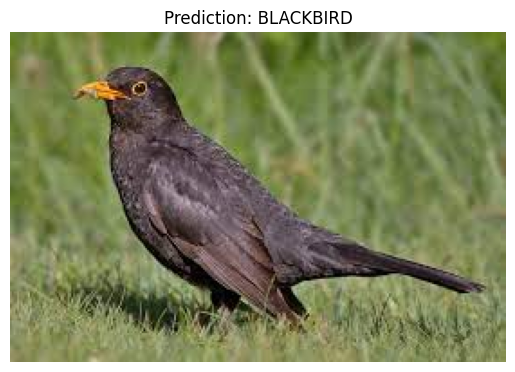

In [11]:
# amsel - blackbird
pred_and_plot(model,amsel, class_names)

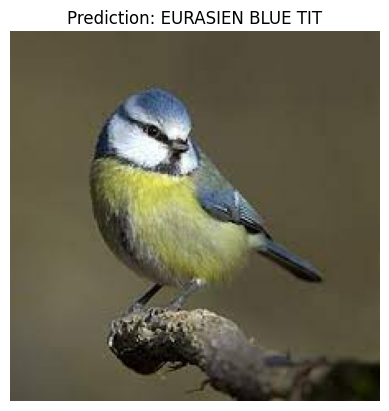

In [12]:
#blaumeise - Eurasian blue tit
pred_and_plot(model,blaumeise, class_names)

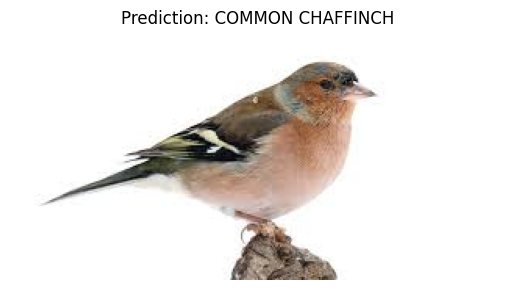

In [13]:
#buchfink - common chaffinch
pred_and_plot(model,buchfink, class_names)

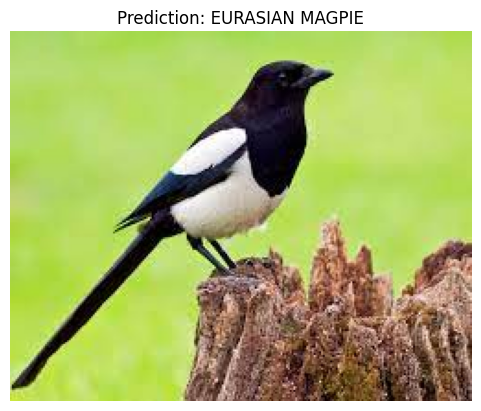

In [14]:
#elster - Eurasien magpie
pred_and_plot(model,elster, class_names)

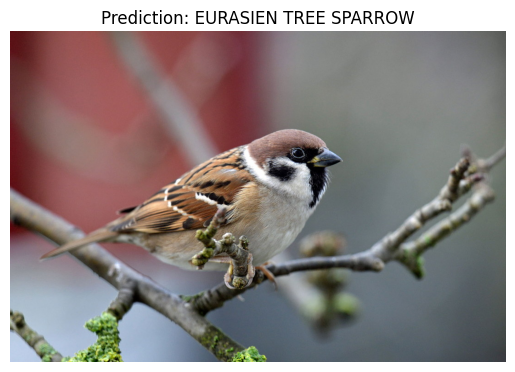

In [15]:
#feldsperling - Eurasian tree sparrow
pred_and_plot(model,feldsperling, class_names)

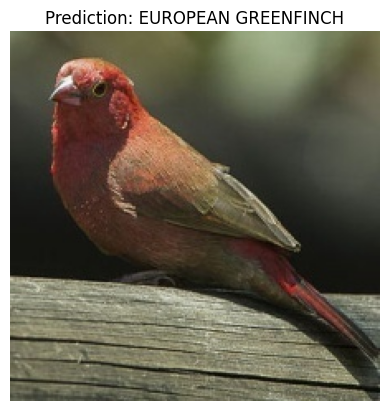

In [16]:
#firefinch - 
pred_and_plot(model,firefinch, class_names)

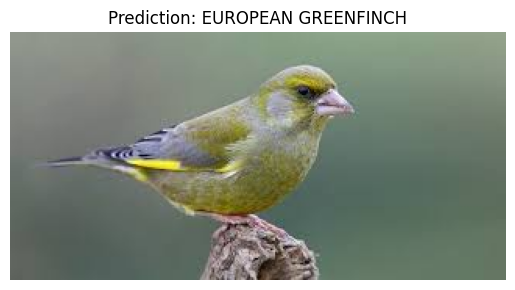

In [17]:
#gruenfink - European greenfinch
pred_and_plot(model,gruenfink, class_names)

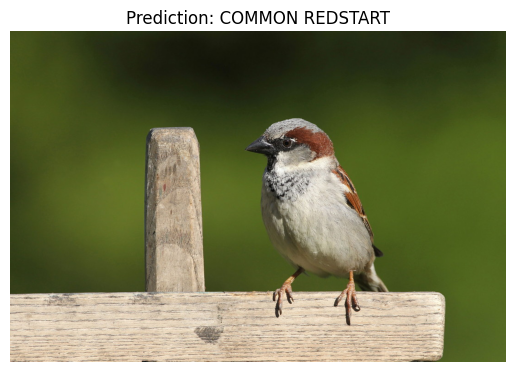

In [18]:
#haussperling - house sparrow
pred_and_plot(model,haussperling, class_names)

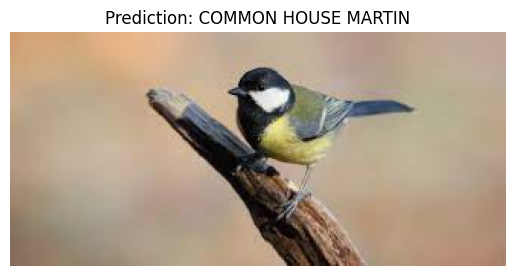

In [19]:
#kohlmeise - Great tit
pred_and_plot(model,kohlmeise, class_names)

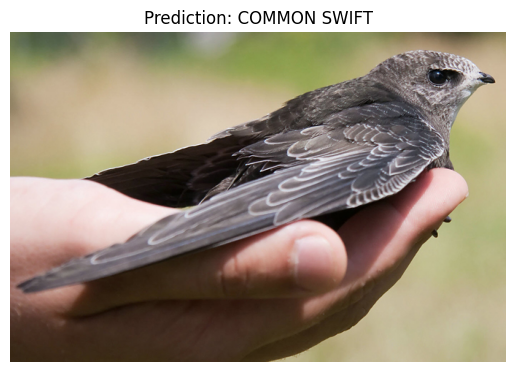

In [20]:
#mauersegler - Common Swift
pred_and_plot(model,mauersegler, class_names)

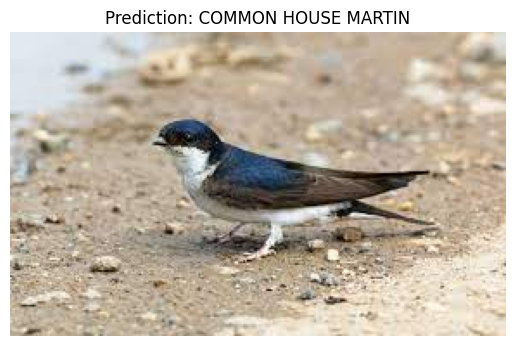

In [21]:
#mehlschwalbe - Common House Martin
pred_and_plot(model,mehlschwalbe, class_names)

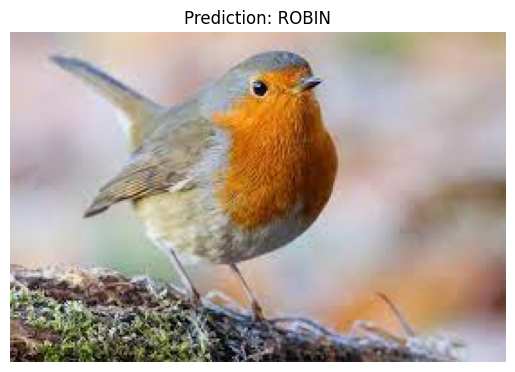

In [22]:
# rotkehlchen - European Robin
pred_and_plot(model,rotkehlchen, class_names)

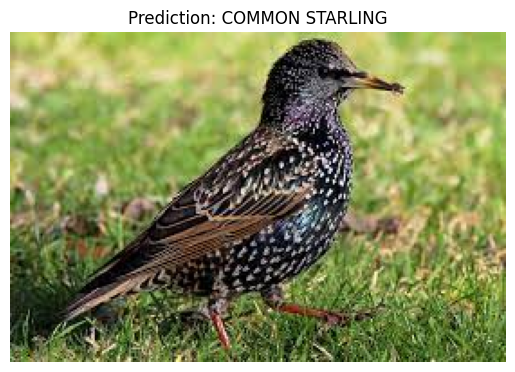

In [23]:
# star - common starling
pred_and_plot(model,star, class_names)

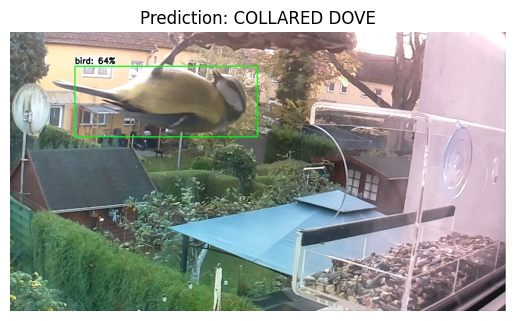

In [24]:
#blaumeise - Eurasian blue tit
pred_and_plot(model,blaumeise1, class_names)

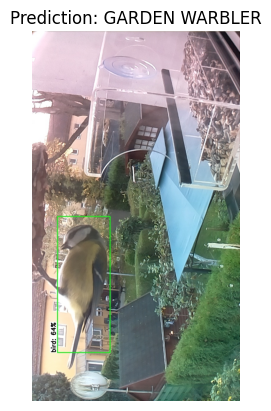

In [25]:
#blaumeise - Eurasian blue tit
pred_and_plot(model,blaumeise2, class_names)

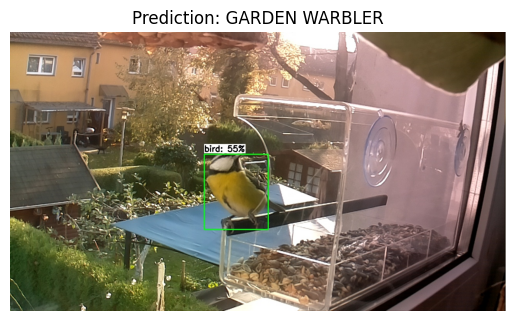

In [26]:
#blaumeise - Eurasian blue tit
pred_and_plot(model,blaumeise3, class_names)